# Mapillary dataset

### new labeling, data augmentation

Source of image augmentation:
https://imgaug.readthedocs.io/en/latest/index.html

In [28]:
import pandas as pd
import os
import numpy as np
import imgaug.augmenters as iaa
import cv2
import matplotlib.pyplot as plt
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

## Filter dataset: prohibitory signs

In [2]:
# Read labels grouped by object
grouped_by_object = pd.read_csv("dataset_object_by_object.csv",sep=",", index_col=0)
grouped_by_object

name  width  height  \
0       --48MAqc82-bZdgGpaiexA   4160    3120   
1       --48MAqc82-bZdgGpaiexA   4160    3120   
2       -0VXKtcnkYsZ9j-haB0PJw   1280     720   
3       -0VXKtcnkYsZ9j-haB0PJw   1280     720   
4       -0VXKtcnkYsZ9j-haB0PJw   1280     720   
...                        ...    ...     ...   
206381  z__Me7KoP05iofqCOkYctQ   4032    3024   
206382  z__Me7KoP05iofqCOkYctQ   4032    3024   
206383  z__Me7KoP05iofqCOkYctQ   4032    3024   
206384  z__Me7KoP05iofqCOkYctQ   4032    3024   
206385  z__Me7KoP05iofqCOkYctQ   4032    3024   

                                  class         xmin         ymin  \
0                            other-sign  2657.890625  1013.085938   
1                            other-sign  2641.640625  1028.320312   
2       complementary--chevron-left--g5   610.937500   354.726562   
3       complementary--chevron-left--g5   554.062500   368.789062   
4       complementary--chevron-left--g5   540.000000   372.656250   
...                                 ...          ...          ...   
206381          warning--curve-left--g2  1368.281250  1714.289062   
206382                       other-sign  3394.125000  1864.160156   
206383                       other-sign  3072.234375  1922.484375   
206384                       other-sign  2288.671875  1897.382812   
206385                       other-sign  2690.296875  1898.121094   

               xmax         ymax  
0       2695.468750  1051.171875  
1       2683.281250  1064.121094  
2        650.000000   390.761719  
3        578.437500   388.828125  
4        554.062500   387.949219  
...             ...          ...  
206381  1571.062500  1921.007812  
206382  3502.406250  1966.042969  
206383  3121.453125  1981.546875  
206384  2311.312500  1930.605469  
206385  2731.640625  1936.511719  

[206386 rows x 8 columns]

In [3]:
number_of_all_images = grouped_by_object['name'].value_counts()
number_of_all_images

name
Pm6K8ZIb2T3AK9dtbd0J1Q    73
Wg5QYHx4nOuwi7irAjK-sw    52
rI9mJoQ6toQtlEpjKljboQ    50
OmUDqwBZWLLLofbPc09Fag    42
dMXTg-9bs5lxY6ulwZ_5Fw    41
                          ..
TmWEPtJmeVc63YVWzfOxfw     1
TmFR1FvZUxCdq9meQFbkFA     1
nl1cObzLizm-jyy3GHavDQ     1
TMeH6V0iKu90IH9U61aOQg     1
ah2Suh5z3YFasIGQdRdTQw     1
Name: count, Length: 41778, dtype: int64

In [4]:
# Needed classes
class_ids = [
    'no-right-left-or-u-turn',
    'speed-limit',
    'road-closed',
    'no-entry',
    'no-stopping-no-parking',
    'other'
]

In [5]:
# Categories to rename
class_renames = {'regulatory--height-limit--g1': 'other',
                 'regulatory--maximum-speed-limit-5--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-10--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-15--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-20--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-25--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-30--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-40--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-45--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-50--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-60--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-70--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-80--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-90--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-100--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-110--g1': 'speed-limit',
                 'regulatory--maximum-speed-limit-120--g1': 'speed-limit',
                 'regulatory--minimum-safe-distance--g1': 'other',
                 'regulatory--no-bicycles--g1': 'other',
                 'regulatory--no-entry--g1': 'no-entry',
                 'regulatory--no-heavy-goods-vehicles--g1': 'other',
                 'regulatory--no-left-turn--g1': 'no-right-left-or-u-turn',
                 'regulatory--no-left-turn--g2': 'no-right-left-or-u-turn',
                 'regulatory--no-left-turn--g3': 'no-right-left-or-u-turn',
                 'regulatory--no-motorcycles--g1': 'other',
                 'regulatory--no-motorcycles--g2': 'other',
                 'regulatory--no-motor-vehicles-except-motorcycles--g1': 'other',
                 'regulatory--no-motor-vehicles-except-motorcycles--g2': 'other',
                 'regulatory--no-overtaking-by-heavy-goods-vehicles--g1': 'other',
                 'regulatory--no-overtaking--g1': 'other',
                 'regulatory--no-parking--g1': 'no-stopping-no-parking',
                 'regulatory--no-right-turn--g1': 'no-right-left-or-u-turn',
                 'regulatory--no-right-turn--g2': 'no-right-left-or-u-turn',
                 'regulatory--no-right-turn--g3': 'no-right-left-or-u-turn',
                 'regulatory--no-stopping--g15': 'no-stopping-no-parking',
                 'regulatory--no-u-turn--g1': 'no-right-left-or-u-turn',
                 'regulatory--no-u-turn--g2': 'no-right-left-or-u-turn',
                 'regulatory--no-u-turn--g3': 'no-right-left-or-u-turn',
                 'regulatory--road-closed-to-vehicles--g3': 'road-closed',
                 'regulatory--weight-limit--g1': 'other',
                 'regulatory--width-limit--g1': 'other'
                }

In [6]:
# Rename categories
grouped_by_object['class'] = grouped_by_object['class'].replace(class_renames)
grouped_by_object

name  width  height  \
0       --48MAqc82-bZdgGpaiexA   4160    3120   
1       --48MAqc82-bZdgGpaiexA   4160    3120   
2       -0VXKtcnkYsZ9j-haB0PJw   1280     720   
3       -0VXKtcnkYsZ9j-haB0PJw   1280     720   
4       -0VXKtcnkYsZ9j-haB0PJw   1280     720   
...                        ...    ...     ...   
206381  z__Me7KoP05iofqCOkYctQ   4032    3024   
206382  z__Me7KoP05iofqCOkYctQ   4032    3024   
206383  z__Me7KoP05iofqCOkYctQ   4032    3024   
206384  z__Me7KoP05iofqCOkYctQ   4032    3024   
206385  z__Me7KoP05iofqCOkYctQ   4032    3024   

                                  class         xmin         ymin  \
0                            other-sign  2657.890625  1013.085938   
1                            other-sign  2641.640625  1028.320312   
2       complementary--chevron-left--g5   610.937500   354.726562   
3       complementary--chevron-left--g5   554.062500   368.789062   
4       complementary--chevron-left--g5   540.000000   372.656250   
...                                 ...          ...          ...   
206381          warning--curve-left--g2  1368.281250  1714.289062   
206382                       other-sign  3394.125000  1864.160156   
206383                       other-sign  3072.234375  1922.484375   
206384                       other-sign  2288.671875  1897.382812   
206385                       other-sign  2690.296875  1898.121094   

               xmax         ymax  
0       2695.468750  1051.171875  
1       2683.281250  1064.121094  
2        650.000000   390.761719  
3        578.437500   388.828125  
4        554.062500   387.949219  
...             ...          ...  
206381  1571.062500  1921.007812  
206382  3502.406250  1966.042969  
206383  3121.453125  1981.546875  
206384  2311.312500  1930.605469  
206385  2731.640625  1936.511719  

[206386 rows x 8 columns]

In [7]:
#Dataframe conntaining only the needed classes
filtered_obj = grouped_by_object[grouped_by_object['class'].isin(class_ids)]
filtered_obj

name  width  height                    class  \
7       -1CbHBwZ5qEz-uT8-RC3tw   4128    3096   no-stopping-no-parking   
41      -64a-Nxf8KSE2xM9EF90zg   1280     720              speed-limit   
47      -6ELIXBsbAjcFUarWGRaow   4032    3024              speed-limit   
64      -AcmoBAQMsDGwzmG9tzAJw   3264    2448              speed-limit   
80      -cOu9CgYcqWytzymAsYA0A   3264    2448   no-stopping-no-parking   
...                        ...    ...     ...                      ...   
206303  zZEohFs0d8JE1ksV5kDLhA   2652    3976  no-right-left-or-u-turn   
206332  zzkvo2ghOPP7_68RNP7wHg   5312    2988   no-stopping-no-parking   
206334  zzkvo2ghOPP7_68RNP7wHg   5312    2988   no-stopping-no-parking   
206335  zzkvo2ghOPP7_68RNP7wHg   5312    2988   no-stopping-no-parking   
206364  z_e2Zi6PwyBoUTCU3ElDxg   4160    3120              speed-limit   

               xmin         ymin         xmax         ymax  
7       1161.000000  1742.255859  1202.320312  1780.804688  
41       680.312500   392.167969   694.375000   406.406250  
47      1418.484375  2085.644531  1482.468750  2142.492188  
64      2786.671875   412.382812  2849.625000   465.574219  
80      2579.484375  1206.070312  2634.468750  1258.664062  
...             ...          ...          ...          ...  
206303   736.810547  2484.029297   762.061523  2546.154297  
206332  3292.765625  2009.021484  3325.187500  2041.848633  
206334  1701.500000  1971.817383  1814.328125  2068.839844  
206335  4771.203125  2232.975586  5162.859375  2556.140625  
206364  1693.046875  2019.316406  1717.421875  2048.261719  

[13550 rows x 8 columns]

In [8]:
# Dataset grouped by image
grouped_df = filtered_obj.groupby(['name']).agg({col:lambda x: list(x) for col in filtered_obj.columns[1:]}).reset_index()
grouped_df

name               width              height  \
0     --7fWq6WjZM8L1eUSuvOEA              [4160]              [3120]   
1     -0G6gt8ksR0hO5jMKrTDMw              [4032]              [3024]   
2     -0oqTZyDwf6SJlJXaHSTVg              [3840]              [2160]   
3     -1CbHBwZ5qEz-uT8-RC3tw              [4128]              [3096]   
4     -1dYvHaY52PTrihdjPDPQg        [5248, 5248]        [3936, 3936]   
...                      ...                 ...                 ...   
9210  zySD1NDQYfO5ZbtPONFERg              [1920]              [1080]   
9211  zysNxmnTNk5QJHkr0X1VgQ              [5660]              [2830]   
9212  zyvgV0FTTRCQ2IDlErkKkA        [1280, 1280]          [720, 720]   
9213  zz8PLMSWqZMXPVK6tzmfug              [3264]              [2448]   
9214  zzkvo2ghOPP7_68RNP7wHg  [5312, 5312, 5312]  [2988, 2988, 2988]   

                                                  class  \
0                                               [other]   
1                                            [no-entry]   
2                                            [no-entry]   
3                              [no-stopping-no-parking]   
4      [no-stopping-no-parking, no-stopping-no-parking]   
...                                                 ...   
9210                          [no-right-left-or-u-turn]   
9211                                      [speed-limit]   
9212                         [speed-limit, speed-limit]   
9213                                      [speed-limit]   
9214  [no-stopping-no-parking, no-stopping-no-parkin...   

                                    xmin  \
0                           [1480.78125]   
1                          [1776.796875]   
2                               [1267.5]   
3                               [1161.0]   
4                [2217.84375, 5009.6875]   
...                                  ...   
9210                         [1557.1875]   
9211                   [1880.6787109375]   
9212                [555.3125, 885.9375]   
9213                        [322.734375]   
9214  [3292.765625, 1701.5, 4771.203125]   

                                                   ymin  \
0                                       [1327.67578125]   
1                                        [1932.8203125]   
2                                        [890.68359375]   
3                                      [1742.255859375]   
4                             [2313.9375, 1851.7265625]   
...                                                 ...   
9210                                    [311.396484375]   
9211                                 [1298.23486328125]   
9212                           [434.53125, 452.4609375]   
9213                                    [1529.40234375]   
9214  [2009.021484375, 1971.8173828125, 2232.9755859...   

                                       xmax  \
0                                 [1576.25]   
1                             [1800.421875]   
2                                  [1305.0]   
3                            [1202.3203125]   
4                    [2403.625, 5246.71875]   
...                                     ...   
9210                            [1607.8125]   
9211                      [1930.4248046875]   
9212                     [571.25, 902.1875]   
9213                           [353.015625]   
9214  [3325.1875, 1814.328125, 5162.859375]   

                                               ymax  
0                                    [1421.3671875]  
1                                    [1956.4453125]  
2                                    [951.85546875]  
3                                    [1780.8046875]  
4                       [2546.484375, 2191.8984375]  
...                                             ...  
9210                                 [369.66796875]  
9211                              [1355.5810546875]  
9212                      [455.80078125, 473.90625]  
9213                                  [1565.859375]  
9214  [2041.8486328125, 2068.83984375, 2556.140625]  

In [9]:
# Save dataframe
#grouped_df.to_csv("grouped_by_image_new_classes.csv")

In [10]:
# delete the unnecessary files

image_names_to_keep = grouped_df['name'].tolist() # list of image filenames

folder_paths = ['./train_0/reduced', './train_1/reduced', './train_2/reduced', './val/reduced']

num_deleted_images = 0
for folder_path in folder_paths:
    
    all_files = os.listdir(folder_path)
    files_to_delete = [file for file in all_files if os.path.splitext(file)[0] not in image_names_to_keep]

    
    for file_to_delete in files_to_delete:
        file_path = os.path.join(folder_path, file_to_delete)
        
        os.remove(file_path)
        num_deleted_images +=1
        
        #print(f"Deleted: {file_path}")
        
print('Number of deleted images: ', num_deleted_images)

Number of deleted images:  32694


In [22]:
# Distribution of the classes (all filtered data)

number_of_classes = filtered_obj['class'].value_counts()
number_of_classes

class
speed-limit                5244
no-stopping-no-parking     2432
no-entry                   2048
other                      1878
no-right-left-or-u-turn    1678
road-closed                 270
Name: count, dtype: int64

## Train test val split

In [18]:
# calculation og the number of each set

train_ratio = 0.7
test_ratio = 0.2

num_train = int(len(grouped_df) * train_ratio)
num_test = int(len(grouped_df) * test_ratio)
num_val = len(grouped_df) - num_train - num_test

print('number of train images: ',num_train,'\nnumber of test images: ',num_test,'\nnumber of validation images: ',num_val)

number of train images:  6450 
number of test images:  1843 
number of validation images:  922


In [21]:
filenames = grouped_df['name']
np.random.seed(12)
np.random.shuffle(filenames)

train_set = filenames[:num_train]
test_set = filenames[num_train:num_train + num_test]
val_set =filenames[-num_val:]

with open('train.txt', 'w') as f_train:
    f_train.write('\n'.join(train_set))

with open('test.txt', 'w') as f_test:
    f_test.write('\n'.join(test_set))

with open('validation.txt', 'w') as f_val:
    f_val.write('\n'.join(val_set))

C:\Users\jaroi\AppData\Local\Temp\ipykernel_15648\714712138.py:3: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(filenames)


In [23]:
train_set

0       RTB6jAyEYn-fcHldK7Jq8A
1       zBZBWu5wUCaL0aUdvKv9Gw
2       vGvGlYLOEg_tWyH3GxIv0Q
3       1uKZ1u70_o5Hce1YG5Sk8g
4       PqUw4s44i6jJFv4iO9AXsg
                 ...          
6445    7KXHpMPO7hX7vQ5j0K8JDA
6446    xaOoTQ9zUe5zIYZVz1NBFQ
6447    1-WyOuy_Gs9xXjP_CaUl8Q
6448    hSp62XCdM50AxNvUdNZArQ
6449    ag6JbV8ji4ri1ZBQEsiEDQ
Name: name, Length: 6450, dtype: object

In [24]:
# filtered_obj_train: train set grouped by objects
# filtered_obj: grouped by object, filtered
# grouped_df: grouped by image, filtered

filtered_obj_train = filtered_obj[filtered_obj['name'].isin(train_set)]
num_of_classes_train = filtered_obj_train['class'].value_counts()
num_of_classes_train

class
speed-limit                3685
no-stopping-no-parking     1723
no-entry                   1441
other                      1298
no-right-left-or-u-turn    1167
road-closed                 204
Name: count, dtype: int64

The data augmentation should be done on the train set, and the final number of images of the classes should match the number of elements of the largest class (speed limit ~3600)

In [26]:
filtered_obj_train


name  width  height                    class  \
41      -64a-Nxf8KSE2xM9EF90zg   1280     720              speed-limit   
64      -AcmoBAQMsDGwzmG9tzAJw   3264    2448              speed-limit   
115     -dxXjzBb0p9C8cVtP0o7qQ   4032    3024   no-stopping-no-parking   
117     -dxXjzBb0p9C8cVtP0o7qQ   4032    3024   no-stopping-no-parking   
261     -90LVyAGTR2pzUEmy8NY5w   3264    1836  no-right-left-or-u-turn   
...                        ...    ...     ...                      ...   
206148  zVvfkAVkphbESkjpTgjpJQ   2448    2048              speed-limit   
206197  zw4c48tBSmPSaXJuFR8Tcg   4032    3024   no-stopping-no-parking   
206274  zz8PLMSWqZMXPVK6tzmfug   3264    2448              speed-limit   
206303  zZEohFs0d8JE1ksV5kDLhA   2652    3976  no-right-left-or-u-turn   
206364  z_e2Zi6PwyBoUTCU3ElDxg   4160    3120              speed-limit   

               xmin         ymin         xmax         ymax  
41       680.312500   392.167969   694.375000   406.406250  
64      2786.671875   412.382812  2849.625000   465.574219  
115     2150.859375  1248.433594  2214.843750  1315.617188  
117     3886.312500  1351.792969  3948.328125  1433.742188  
261     1157.062500   586.300781  1264.640625   699.706055  
...             ...          ...          ...          ...  
206148   881.542969  1176.500000   935.332031  1230.000000  
206197  2277.843750  1993.359375  2336.906250  2047.992188  
206274   322.734375  1529.402344   353.015625  1565.859375  
206303   736.810547  2484.029297   762.061523  2546.154297  
206364  1693.046875  2019.316406  1717.421875  2048.261719  

[9518 rows x 8 columns]

In [25]:
grouped_df_train = grouped_df = filtered_obj_train.groupby(['name']).agg({col:lambda x: list(x) for col in filtered_obj_train.columns[1:]}).reset_index()
grouped_df_train

name         width        height  \
0     --7fWq6WjZM8L1eUSuvOEA        [4160]        [3120]   
1     -0oqTZyDwf6SJlJXaHSTVg        [3840]        [2160]   
2     -1dYvHaY52PTrihdjPDPQg  [5248, 5248]  [3936, 3936]   
3     -3vUvRIrj_BvNn9mBS9gHg        [4096]        [3072]   
4     -4Kw4AJqOzZG8q5le7bGlQ        [3264]        [2448]   
...                      ...           ...           ...   
6445  zxjcGajpospbBN5a6PxHmA        [4032]        [3024]   
6446  zySD1NDQYfO5ZbtPONFERg        [1920]        [1080]   
6447  zysNxmnTNk5QJHkr0X1VgQ        [5660]        [2830]   
6448  zyvgV0FTTRCQ2IDlErkKkA  [1280, 1280]    [720, 720]   
6449  zz8PLMSWqZMXPVK6tzmfug        [3264]        [2448]   

                                                 class  \
0                                              [other]   
1                                           [no-entry]   
2     [no-stopping-no-parking, no-stopping-no-parking]   
3                                           [no-entry]   
4                                        [speed-limit]   
...                                                ...   
6445                                     [speed-limit]   
6446                         [no-right-left-or-u-turn]   
6447                                     [speed-limit]   
6448                        [speed-limit, speed-limit]   
6449                                     [speed-limit]   

                         xmin                       ymin  \
0                [1480.78125]            [1327.67578125]   
1                    [1267.5]             [890.68359375]   
2     [2217.84375, 5009.6875]  [2313.9375, 1851.7265625]   
3                    [2878.0]                  [1934.25]   
4                 [2004.9375]            [1230.57421875]   
...                       ...                        ...   
6445            [3249.421875]            [1982.28515625]   
6446              [1557.1875]            [311.396484375]   
6447        [1880.6787109375]         [1298.23486328125]   
6448     [555.3125, 885.9375]   [434.53125, 452.4609375]   
6449             [322.734375]            [1529.40234375]   

                        xmax                         ymax  
0                  [1576.25]               [1421.3671875]  
1                   [1305.0]               [951.85546875]  
2     [2403.625, 5246.71875]  [2546.484375, 2191.8984375]  
3                   [2900.0]                    [1986.75]  
4              [2077.453125]              [1304.68359375]  
...                      ...                          ...  
6445             [3405.9375]              [2141.75390625]  
6446             [1607.8125]               [369.66796875]  
6447       [1930.4248046875]            [1355.5810546875]  
6448      [571.25, 902.1875]    [455.80078125, 473.90625]  
6449            [353.015625]                [1565.859375]  

[6450 rows x 8 columns]

## Data augmentation

In [44]:
# Define the augmentation sequence

augmentation = iaa.Sequential([
    iaa.Fliplr(0.4),  # Horizontal flip with a 40% probability
    
    # Affine transformations
    iaa.Affine(
        rotate=(-10, 10),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        shear=(-10, 10)
    ),
    # Gaussian blur with random sigma between 0 and 1.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 1))
    ),
    # Sharpen with 50% probability
    iaa.Sometimes(
        0.5,
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))
    ),
    # change brightness, doesn't affect BBs
    iaa.Multiply((1.2, 1.5)),
    
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5))
    
    ])

### 1. Data augmentation on 5 example images

Bounding box change: (1161.0000, 1742.2559, 1202.3203, 1780.8047) -> (1900.2296, 2164.8450, 1942.4777, 2208.7236)


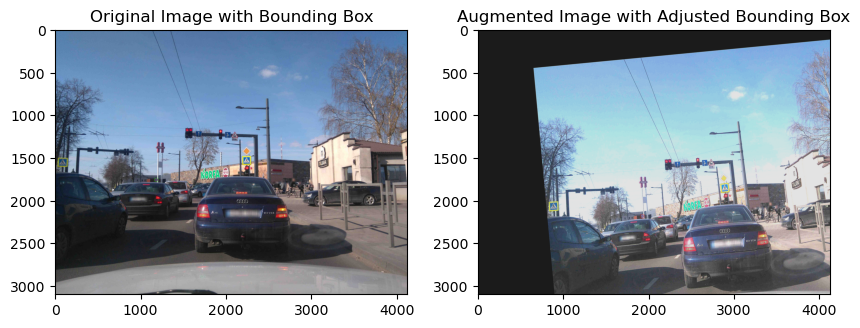

Bounding box change: (680.3125, 392.1680, 694.3750, 406.4062) -> (618.3351, 327.9831, 631.4399, 344.7135)


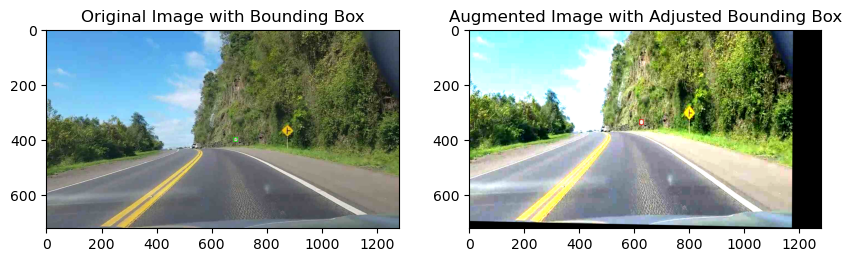

Bounding box change: (1418.4844, 2085.6445, 1482.4688, 2142.4922) -> (2856.5337, 2750.5010, 2930.1377, 2816.3689)


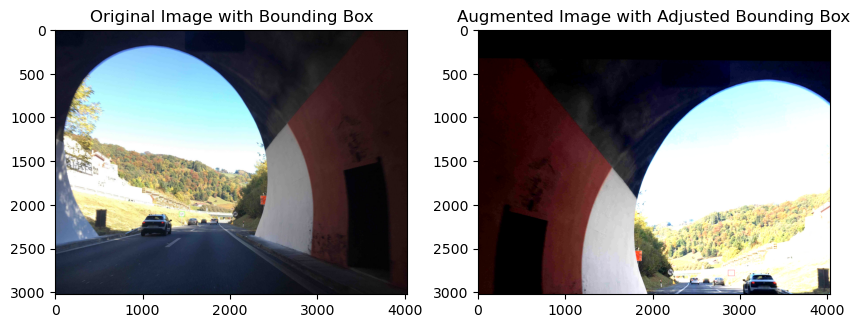

Bounding box change: (2786.6719, 412.3828, 2849.6250, 465.5742) -> (-50.6841, -35.2015, 17.1332, 20.4233)


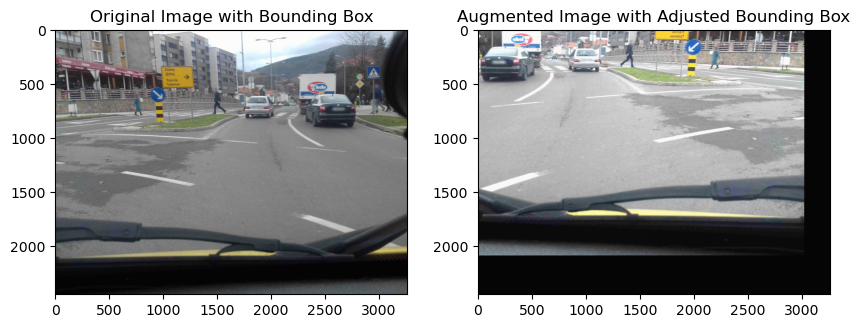

Bounding box change: (2579.4844, 1206.0703, 2634.4688, 1258.6641) -> (684.0164, 732.0524, 744.8251, 787.6057)


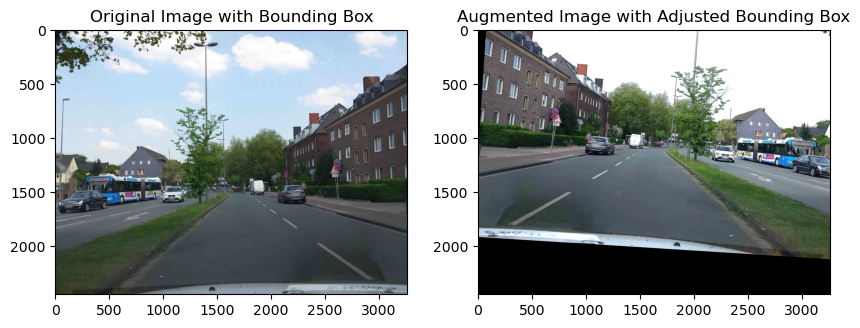

In [45]:
# Apply augmentation to the first 5 rows (example images)

for index, row in filtered_obj.head(5).iterrows():
    
    image_path = f"./example_images/{row['name']}.jpg"
    image = cv2.imread(image_path)
    
    # Extract bounding box coordinates
    bbs = BoundingBoxesOnImage([
        BoundingBox(x1=row['xmin'], y1=row['ymin'], x2=row['xmax'], y2=row['ymax'])
    ], shape=image.shape)
    
    # Apply augmentation
    augmented_image, augmented_bboxes = augmentation(image=image, bounding_boxes=bbs)
    
    # Print bounding boxes
    print("Bounding box change: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        bbs.bounding_boxes[0].x1, bbs.bounding_boxes[0].y1, bbs.bounding_boxes[0].x2, bbs.bounding_boxes[0].y2,
        augmented_bboxes.bounding_boxes[0].x1, augmented_bboxes.bounding_boxes[0].y1, augmented_bboxes.bounding_boxes[0].x2, augmented_bboxes.bounding_boxes[0].y2)
    )
    
    # image with BBs before/after augmentation
    image_before = bbs.draw_on_image(image, size=2)
    image_after = augmented_bboxes.draw_on_image(augmented_image, size=2, color=[0, 0, 255])

    # Visualize the original and augmented images with bounding boxes
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_before, cv2.COLOR_BGR2RGB))
    plt.title('Original Image with Bounding Box')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_after, cv2.COLOR_BGR2RGB))
    plt.title('Augmented Image with Adjusted Bounding Box')
    plt.show()
    


Hard to spot te bounding box, because of its small size, but in these examples the boxes transformed well.

### Data augmentation of the train set

In [46]:
# Creating one folder from old 4

source_folder1 = './train_0/reduced'
source_folder2 = './train_1/reduced'
source_folder3 = './train_2/reduced'
source_folder4 = './val/reduced'
destination_folder = './all_images'

os.makedirs(destination_folder, exist_ok=True)

# Function to move the contents of a source folder to the destination folder
def move_contents(source_folder, destination_folder):
    for item in os.listdir(source_folder):
        source_item_path = os.path.join(source_folder, item)
        destination_item_path = os.path.join(destination_folder, item)

        if os.path.isdir(source_item_path):
            os.makedirs(destination_item_path, exist_ok=True)
            move_contents(source_item_path, destination_item_path)
            os.rmdir(source_item_path)
        else:
            
            os.rename(source_item_path, destination_item_path)

move_contents(source_folder1, destination_folder)
move_contents(source_folder2, destination_folder)
move_contents(source_folder3, destination_folder)
move_contents(source_folder4, destination_folder)

In [90]:
df = filtered_obj_train
images_dir = './all_images'

output_dir = './augmented_images_train'
os.makedirs(output_dir, exist_ok=True)

class_counts = df['class'].value_counts()

target_objects_per_class = class_counts.max()
print('Target object per class: ',target_objects_per_class)

Target object per class:  3685


In [91]:
# New DataFrame to store augmented images
augmented_df = pd.DataFrame(columns=df.columns)

In [92]:
# For now: only for one class (road-closed) to test
#for class_name, count in class_counts.items(): # this is for all classes
class_name='road-closed'
count = 204
if class_name == 'road-closed':
    
    # choosing one class
    class_subset = df[df['class'] == class_name]
    
    # oversampling factor
    oversampling_factor = (target_objects_per_class // count )+1
    class_subset_oversampled = pd.concat([class_subset] * oversampling_factor, ignore_index=True)

    # subset selection
    #print(subset_size)
    subset_size = min(target_objects_per_class, len(class_subset_oversampled))
    class_subset_selected = class_subset_oversampled.sample(subset_size, random_state=42)
    
    # image augmentation
    for index, row in class_subset_selected.iterrows():
        original_image_path = f"{images_dir}/{row['name']}.jpg"
        #if index == 471:
        if True:
            
            original_image = cv2.imread(original_image_path)
            
            
            # Extract bounding box coordinates
            boundingboxes = BoundingBoxesOnImage([
                BoundingBox(x1=row['xmin'], y1=row['ymin'], x2=row['xmax'], y2=row['ymax'])
            ], shape=original_image.shape)  

            #print(boundingboxes)

            # Apply augmentation
            augmented_image, augmented_bboxes = augmentation(image=original_image,bounding_boxes=boundingboxes)
            augmented_bboxes=augmented_bboxes.bounding_boxes[0]
            #print(augmented_bboxes)
            #plt.figure()
            #plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
            
           
            augmented_image_name = f"{os.path.splitext(row['name'])[0]}_{index}_aug.jpg"
            augmented_image_path = os.path.join(output_dir, augmented_image_name)
            #print(augmented_image_path)
           
            cv2.imwrite(augmented_image_path, augmented_image)
            
            
            augmented_row = pd.DataFrame([{
                'name': f"{os.path.splitext(row['name'])[0]}_{index}_aug",
                'width': row['width'],  
                'height': row['height'],  
                'class': row['class'],  
                'xmin': augmented_bboxes.x1,
                'ymin': augmented_bboxes.y1,
                'xmax': augmented_bboxes.x2,
                'ymax': augmented_bboxes.y2,
            }])
            
            
            augmented_df = pd.concat([augmented_df, augmented_row], ignore_index=True)

            
        
augmented_df
    

name width height        class         xmin  \
0     hzlM917YtiazVQzFBL8kCw_3819_aug  4032   3024  road-closed   621.465820   
1     HcYl32I27DcQPFISMtgacw_3748_aug  4032   3024  road-closed  2968.917236   
2     5EMpP9GmwHDBQz8YcZ3_oQ_2289_aug  4032   3024  road-closed  2231.174805   
3     9wyk0xrm1mdAu3C3GbVlqQ_2500_aug  3264   2448  road-closed  2331.926758   
4     zUfI8ZBn02wK2VTzv6GgvQ_2240_aug  5248   3936  road-closed  3731.258301   
...                               ...   ...    ...          ...          ...   
3680  utZDIE9pJHwUck1mE_eJew_3242_aug  4032   3024  road-closed  1423.394653   
3681  6O-zO4TRP8U6hoQYfCrZQA_1678_aug  3984   2988  road-closed  2031.697266   
3682  h-Hf-yv5r6_rQ4DZarNrew_2796_aug  4032   3024  road-closed  2442.929443   
3683  C9Cy-eUHARvbuSxTSrnhjA_3733_aug  5248   3936  road-closed  2609.655273   
3684  G3O6zdJF9VpGi4cEbxlVwQ_3478_aug  3264   2448  road-closed  2071.004883   

             ymin         xmax         ymax  
0     2752.697266   679.549438  2845.870361  
1     1259.911743  3124.767822  1416.790405  
2      993.338440  2404.653320  1159.384766  
3     1849.428101  2477.331543  1988.043579  
4      953.439514  3781.711182  1019.116638  
...           ...          ...          ...  
3680  1450.149292  1442.003906  1477.893066  
3681    78.012062  2085.419678   165.519745  
3682  2262.051270  2462.375977  2288.920410  
3683  2791.777344  2693.004150  2901.702393  
3684   863.613281  2118.371826   991.884827  

[3685 rows x 8 columns]

In [93]:
# Save dataframe
augmented_df.to_csv("grouped_by_object_augmented_road_closed.csv")

In [94]:
# Dataset grouped by image (one aug image should contain only one object)
grouped_df_aug = augmented_df.groupby(['name']).agg({col:lambda x: list(x) for col in augmented_df.columns[1:]}).reset_index()
#grouped_df_aug.to_csv("grouped_by_image_augmented.csv")
grouped_df_aug

name   width  height          class  \
0     -X7XPBP65Hzq6u-VZvhktQ_1048_aug  [4624]  [3488]  [road-closed]   
1     -X7XPBP65Hzq6u-VZvhktQ_1252_aug  [4624]  [3488]  [road-closed]   
2     -X7XPBP65Hzq6u-VZvhktQ_1456_aug  [4624]  [3488]  [road-closed]   
3     -X7XPBP65Hzq6u-VZvhktQ_1660_aug  [4624]  [3488]  [road-closed]   
4     -X7XPBP65Hzq6u-VZvhktQ_1864_aug  [4624]  [3488]  [road-closed]   
...                               ...     ...     ...            ...   
3680   znYmqCJu-aR6QJ7MxpMGIg_406_aug  [4608]  [3456]  [road-closed]   
3681   znYmqCJu-aR6QJ7MxpMGIg_407_aug  [4608]  [3456]  [road-closed]   
3682   znYmqCJu-aR6QJ7MxpMGIg_610_aug  [4608]  [3456]  [road-closed]   
3683   znYmqCJu-aR6QJ7MxpMGIg_611_aug  [4608]  [3456]  [road-closed]   
3684   znYmqCJu-aR6QJ7MxpMGIg_814_aug  [4608]  [3456]  [road-closed]   

                      xmin                  ymin                  xmax  \
0      [1639.238525390625]   [1932.698974609375]    [1669.43896484375]   
1       [4091.89599609375]  [1686.5223388671875]     [4122.7705078125]   
2      [3146.432373046875]   [1703.468017578125]   [3172.015869140625]   
3     [1008.2877807617188]    [2233.53955078125]    [1043.64404296875]   
4          [2716.05859375]  [1329.9735107421875]     [2748.3408203125]   
...                    ...                   ...                   ...   
3680  [1696.6248779296875]   [1564.758056640625]   [1727.867919921875]   
3681  [261.86187744140625]   [596.6727905273438]   [305.0870361328125]   
3682      [3917.630859375]   [2081.293212890625]    [3954.77197265625]   
3683      [4075.345703125]   [1867.750732421875]    [4114.49462890625]   
3684   [1340.741455078125]  [1780.0953369140625]  [1374.1348876953125]   

                      ymax  
0      [1968.582275390625]  
1     [1729.9566650390625]  
2          [1738.14453125]  
3        [2281.1435546875]  
4     [1375.4954833984375]  
...                    ...  
3680   [1594.844970703125]  
3681   [636.5487670898438]  
3682   [2124.487060546875]  
3683  [1911.6243896484375]  
3684  [1812.3721923828125]  

[3685 rows x 8 columns]

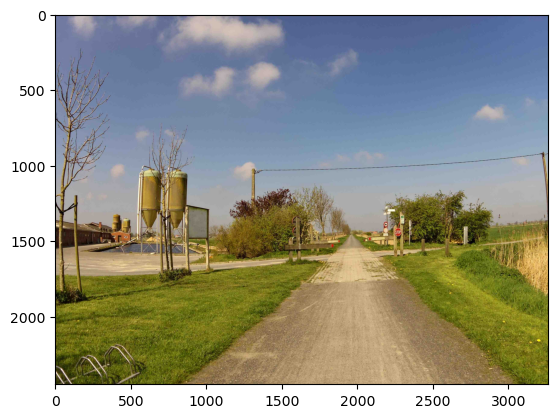

In [97]:
# Visualization of augmented images

#_CkxBP6-SGo-ZYsPhVUa8w.jpg
image_path = r'./all_images/_CkxBP6-SGo-ZYsPhVUa8w.jpg'
og = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(og, cv2.COLOR_BGR2RGB))
plt.show()

In [100]:
filenames = [filename for filename in os.listdir('./augmented_images_train') if 'CkxBP6-SGo-ZYsPhVUa8w' in filename]
#filenames

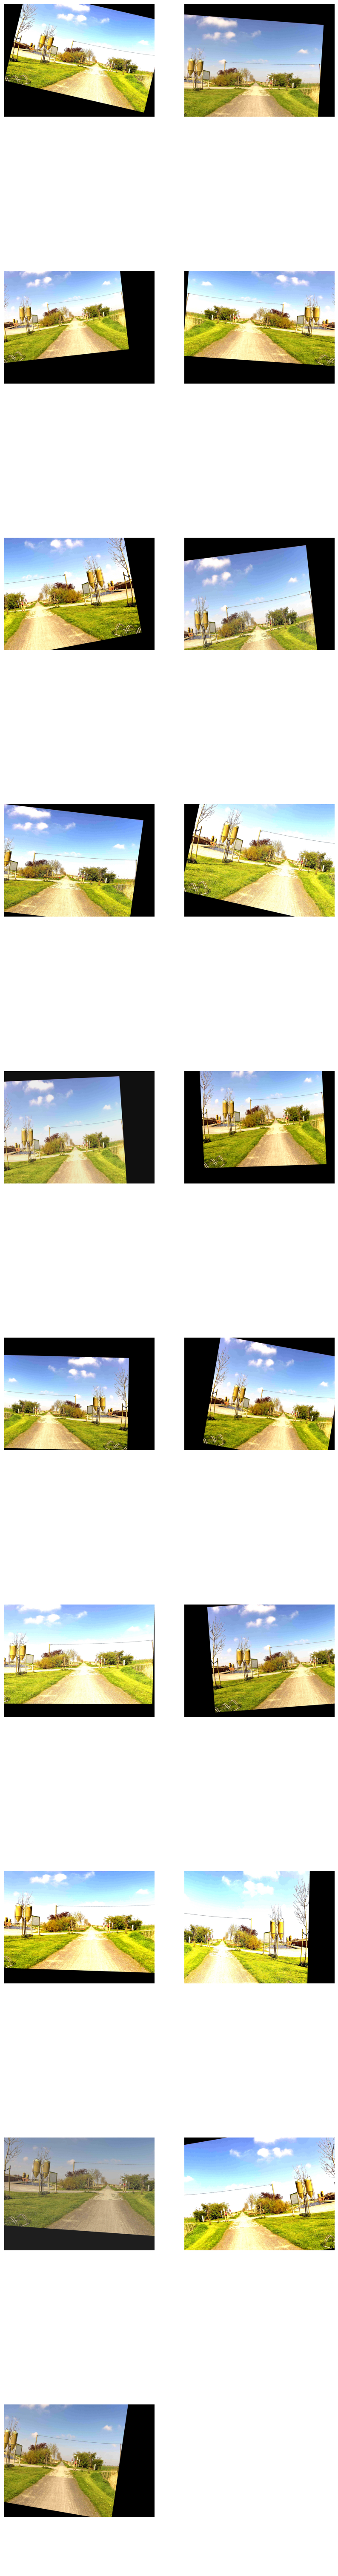

In [108]:
fig, axes = plt.subplots(nrows=10, ncols=2,figsize=(10,80))
axes = axes.flatten()
for i, image_filename in enumerate(filenames):
    
    img_path = os.path.join('./augmented_images_train', image_filename)
    img = cv2.imread(img_path)
    
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

axes[i+1].axis('off')
#plt.tight_layout()
plt.show()